In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from utils.plots import vae_plots
from utils.rbm_plots import plot_rbm_histogram, plot_rbm_params, plot_forward_output_v2

from scripts.run import set_device

[21:41:32.638] INFO   CaloQuVAE                                         Loading configuration.


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [3]:
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config)
    # self.model = self.model.double()


[21:41:44.163] INFO   data.dataManager                                  Loading other dataset: CaloChallenge2
[21:41:44.165] INFO   data.dataManager                                  Keys: ['incident_energies', 'showers']
[21:41:50.368] INFO   data.dataManager                                  dict_keys(['incident_energies', 'showers'])
[21:41:50.370] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f26aebe1160>: 79999 events, 157 batches
[21:41:50.370] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f26ae4890d0>: 10001 events, 10 batches
[21:41:50.371] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f29481f9550>: 9999 events, 10 batches
[21:41:50.371] INFO   model.modelCreator                                ::Creating Model
[21:41:51.096] INFO   dwave.cloud.client.base                           Fetching d

/home/jtoledo/CaloQuVAE


[21:41:53.017] INFO   scripts.run                                       Requesting GPUs. GPU list :[1]
[21:41:53.019] INFO   scripts.run                                       Main GPU : cuda:1
[21:41:53.215] INFO   scripts.run                                       CUDA available


RBM_Hiddentorch initialized
cuda:1


[21:41:53.706] INFO   model.modelCreator                                Loading state


encoder._networks.0.seq1.0.conv.weight True
encoder._networks.0.seq1.0.conv.bias True
encoder._networks.0.seq1.1.weight True
encoder._networks.0.seq1.1.bias True
encoder._networks.0.seq1.2.weight True
encoder._networks.0.seq1.3.conv.weight True
encoder._networks.0.seq1.3.conv.bias True
encoder._networks.0.seq1.4.weight True
encoder._networks.0.seq1.4.bias True
encoder._networks.0.seq1.5.weight True
encoder._networks.0.seq1.6.conv.weight True
encoder._networks.0.seq1.6.conv.bias True
encoder._networks.0.seq1.7.weight True
encoder._networks.0.seq1.7.bias True
encoder._networks.0.seq1.8.weight True
encoder._networks.0.seq2.0.conv.weight True
encoder._networks.0.seq2.0.conv.bias True
encoder._networks.0.seq2.1.weight True
encoder._networks.0.seq2.1.bias True
encoder._networks.0.seq2.2.weight True
encoder._networks.0.seq2.3.conv.weight True
encoder._networks.0.seq2.3.conv.bias True
encoder._networks.0.seq2.4.weight True
encoder._networks.1.seq1.0.conv.weight True
encoder._networks.1.seq1.0.

[21:41:54.228] INFO   model.modelCreator                                Loading weights from file : /fast_scratch_1/caloqvae/jtoledo/wandb/run-20250825_231749-qtzezvdq/files/autoencoderhidden_189.pth


Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  decoder
Loading weights for module =  prior


[21:41:55.495] INFO   model.modelCreator                                Loaded VAE optimizer state
[21:41:55.504] INFO   model.modelCreator                                Loaded RBM optimizer state


In [4]:
self.evaluate_vae(self.data_mgr.val_loader,0)

[21:42:38.314] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 18628.6586


{'val_ae_loss': 16733.74130859375,
 'val_kl_loss': 1.484228515625,
 'val_hit_loss': 1893.433251953125,
 'val_entropy': -10.90633544921875,
 'val_pos_energy': -4638.348974609375,
 'val_neg_energy': 4650.739453125,
 'val_loss': 18628.65859375}

In [8]:
self.prior_samples.shape
self.post_samples.shape
W01.shape

torch.Size([302, 302])

In [5]:
def sigmoid_C_k(weights_ax, weights_bx, weights_cx,
                 pa_state, pb_state, pc_state, bias_x) -> torch.Tensor:
    """partition_state()

    :param weights_a (torch.Tensor) : (n_nodes_a, n_nodes_x)
    :param weights_b (torch.Tensor) : (n_nodes_b, n_nodes_x)
    :param weights_c (torch.Tensor) : (n_nodes_c, n_nodes_x)
    :param pa_state (torch.Tensor) : (batch_size, n_nodes_a)
    :param pb_state (torch.Tensor) : (batch_size, n_nodes_b)
    :param pc_state (torch.Tensor) : (batch_size, n_nodes_c)
    :param bias_x (torch.Tensor) : (n_nodes_x)
    """
    p_activations = (torch.matmul(pa_state, weights_ax) +
                        torch.matmul(pb_state, weights_bx) +
                        torch.matmul(pc_state, weights_cx) + bias_x)
    return torch.sigmoid(p_activations).detach()

In [11]:
p0 = self.post_samples[:self._config.data.batch_size_tr,:302].to(self._device)
p1 = self.post_logits[:self._config.data.batch_size_tr,:302].to(self._device)
p2 = self.post_logits[:self._config.data.batch_size_tr,302:604].to(self._device)
p3 = self.post_logits[:self._config.data.batch_size_tr,604:].to(self._device)

W01 = self.model.prior.weight_dict['01']
W02 = self.model.prior.weight_dict['02']
W03 = self.model.prior.weight_dict['03']

W12 = self.model.prior.weight_dict['12']
W13 = self.model.prior.weight_dict['13']
W23 = self.model.prior.weight_dict['23']
# precompute the needed transposes only once
W12_T = W12.T
W13_T = W13.T
W23_T = W23.T

b1 = self.model.prior.bias_dict['1']
b2 = self.model.prior.bias_dict['2']
b3 = self.model.prior.bias_dict['3']

p3_ans = sigmoid_C_k(W03,   W13,   W23,   p0, p1, p2, b3)
# p2_ans = sigmoid_C_k(W02,   W12, W23_T,   p0, p1, p3, b2)
# p1_ans = sigmoid_C_k(W01, W12_T, W13_T,   p0, p2, p3, b1)
p2_ans = sigmoid_C_k(W02,   W12, W23_T,   p0, p1, p3_ans, b2)
p1_ans = sigmoid_C_k(W01, W12_T, W13_T,   p0, p2, p3_ans, b1)

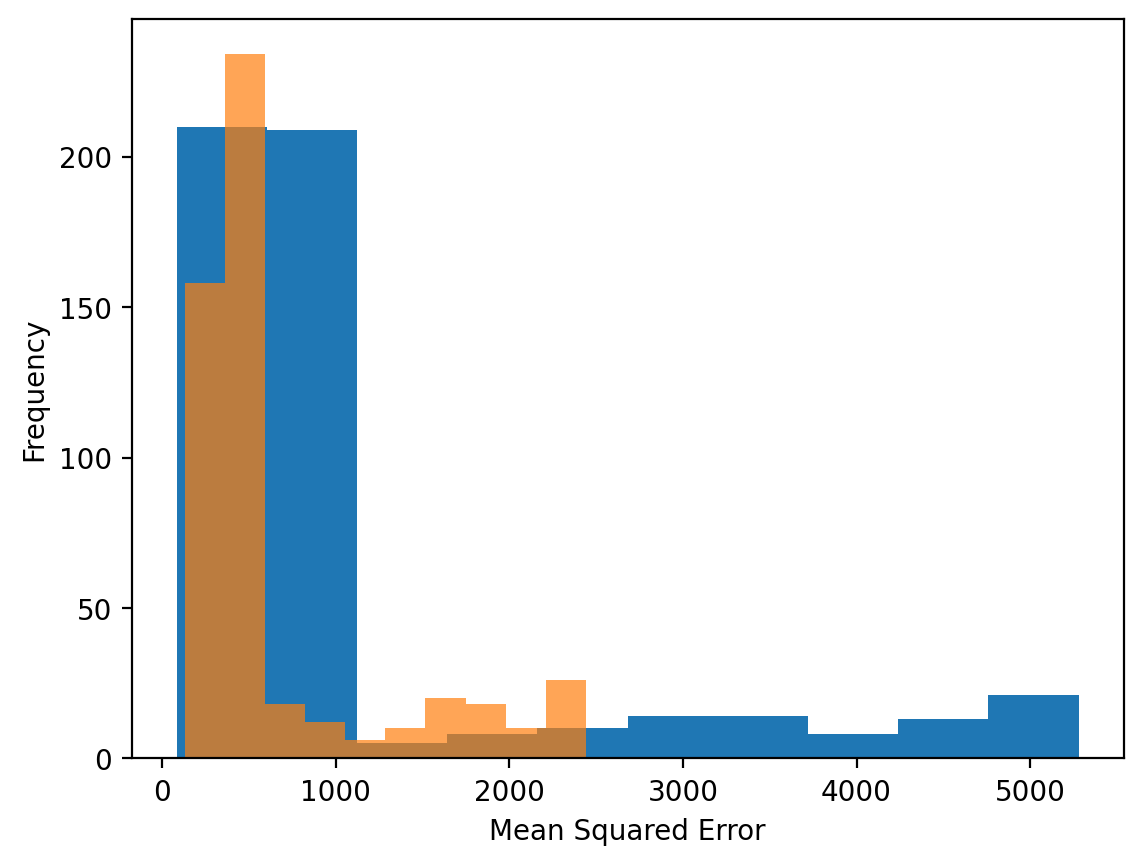

In [12]:
plt.hist((p1 - p1_ans).pow(2).mean(dim=1).cpu(), label='p1')
plt.hist((p2 - p2_ans).pow(2).mean(dim=1).cpu(), label='p2', alpha=0.7)
# plt.hist((p3 - p3_ans).pow(2).mean(dim=1).cpu(), label='p3', alpha=0.5)
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.show()

In [10]:
p3_ans.shape

torch.Size([512, 302])